In [1]:
# Some plotting imports
%matplotlib inline
import matplotlib.pylab as pl
import numpy as np
from IPython.display import HTML, Latex
# Update the matplotlib configuration parameters:
pl.rcParams.update({'font.size': 18, 'font.family': 'serif'})

# Motivation

The usual algorithms used to run wind farm flow models in order to calculate annual energy production is utilizing a lot of nested `for` loops which make them innapropriate for scripting languages such as Matlab of Python. The following code snippet illustrate a typical algorithm to calculate the AEP in python.

```python
AEP = 0.0
for ws in wind_speed_cases:
    for wd in wind_direction_cases:
        for wt in wind_turbines.sort(wd):
            wt.du[ws, wd] = []
            for wt_up in wt.upstream_wind_turbines(wd):
                wt.du[ws, wd].append(calculate_deficit(wt_up, wt, wd, ws))
            wt.ws[ws, wd] = aggregate_wake(wt.du[ws, wd])
            wt.power[ws, wd] = wt.power_curve(wt.ws[ws, wd])
            wt.ct[ws, wd] = wt.ct_curve(wt.ws[ws, wd])            
        AEP += Nt * wt.power[ws, wd] * frequency(ws, wd)
```

As it can be seen the function `calculate_deficit` is called $N_{WS} . N_{WD} . N_{WT} . (N_{WT}-1)/2 $ times. With $N_{WS}$ the number of wind speed case, $N_{WD}$ the number of wind direction case, $N_{WT}$ the number of wind turbines in the wind farm. If those numbers are large, and the time to calculate the wake wind speed deficit is significant then the total time adds up significantly. To estimate the AEP of a 100-turbine wind farm with this method can easily reach 30 million function evaluations.

### Example

The following examples is based on the following inputs:

Number of wind speed bins:

In [2]:
n_ws = 21

Number of wind direction bins

In [3]:
n_wd = 360

Number of wind turbines

In [4]:
n_wt = 100

Which gives us the following number of single wake evaluations for a traditional AEP calculation:

In [5]:
HTML("Number of function evaluations for $N_{WS}=%d$, $N_{WD}=%d$ and $%d$ turbines: %2.2E"%(
        n_ws, n_wd, n_wt, n_ws * n_wd * n_wt * (n_wt - 1)/2))

This is particularly critical in the context of wind farm layout optimization, where the AEP of many different layouts need to be evaluated iteratively. Or in the case of an uncertainty quantification exercise, where 100,000s to millions time more wind direction and wind speed cases have to be executed.
A way to approach this is to put the `for` loops into a compiled language as fast as possible such as Fortran of C. This is done at the expense of the coding flexibility that are offered by modern scripting languages such as Python and Matlab. What we propose in this paper is to explore the potential of using vectorization to reduce the number of function evalutation and dramatically speeding up the calculation of an AEP with uncertainty propagation.

# Method

The methodology is to first make sure that the wake deficit function is vectorizable. So that it can produce a vector output according to a set of vector inputs. 

### Generating a random layout of 100 turbines
Each turbine has a random rotor diameter and random hub height.

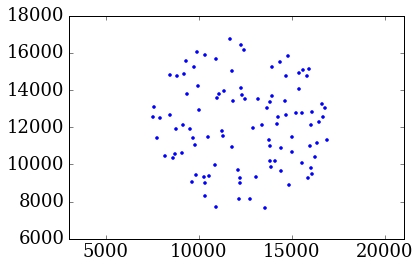

In [6]:
from waketor.lib import generate_random_coord, plot_coord
# Random rotor diameter
D = (np.random.rand(n_wt) + 1.0) * 40.0
# Random hub height
H = (np.random.rand(n_wt) + 1.0) * D/2.0
# Random coordinate 
coord = generate_random_coord(n_wt, 60*D.max(), 3*D.max())
plot_coord(coord)
pl.axis('equal');

Here we only consider an AEP calculation.

### Creating the distance matrix between each wind turbines
In order to call the single wake model, we need to have the relative distance between each wind turbines of the layout. We will use the $(x, y)$-coordinate matrix (of shape $[N_{WT}, 2]$) created previously to generate this new turbine distance matrix (of shape $[N_{WT}^2, 3]$, where the third dimension is due to the difference in hub height). But as we will have to call the single wake function for each wind speed and wind direction, we also have to multiply by those cases as well. So the final matrix should have shape of $[N_{WT}^2 N_{WD} N_{WS}, 3]$

In [12]:
HTML('this corresponds to {} cases'.format(n_ws*n_wd*n_wt**2))

First we generate the indices of the wind turbines to operate over using `numpy.meshgrid` function

In [13]:
WS, WD, Ii, Ij = np.meshgrid(
                    np.linspace(4., 25., n_ws), 
                    np.linspace(0., 2. * np.pi, n_wd)[:-1], 
                    range(n_wt), 
                    range(n_wt))
# We want to operate over vectors
ws = WS.flatten()
wd = WD.flatten()
ii = Ii.flatten()
ij = Ij.flatten()

where iI and iJ are the two matrices of wind turbine index corresponding respectively to the upstream turbine and the downstream turbine.

Then we create the distance matrix `rel_pos`.

In [ ]:
d_x = coord[ij, 0] - coord[ii, 0]
d_y = coord[ij, 1] - coord[ii, 1]
d_z = H[ij] - H[ii]
rel_pos = np.vstack([d_x, d_y, d_z]).T # Transposed to have a shape=[n_wt, 3]
assert rel_pos.shape == (n_wt**2, 3)

### Rotating the coordinate system according to the wind direction
In traditional wind farm flow model algorithm, the coordinate system is transformed in order to align the position of the downstream turbines related to the wake generating turbines.

$(1) \hspace{50pt} 
x = d_x \sin(\theta) + d_y \cos(\theta)
$

$(2) \hspace{50pt}
r = \sqrt{(d_x \cos(\theta) - d_y \sin(\theta))^2 + dz^2}
$

with $r$ the radius, $d_x$, $d_y$ and $d_z$ the distance between two turbines in $x$, $y$ and $z$-direction and $\theta$ the wind direction.

In [ ]:
# First we have to create new vector containing all the wind turbine pairs with respect to all directions
wd = WD.flatten()
iWD, iII = np.meshgrid(range(wd.size), ii)
iwd = iWD.flatten()
iii = iII.flatten()

x = np.sin(wd) * d_x + np.cos(wd) * dy
r = np.sqrt((np.cos(wd) * d_x - np.sin(wd) * d_y) ** 2.0 + d_z ** 2.0)